In [14]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

file_path = "2015_Zika.csv"  # <-- thay bằng tên thật trong dataset

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "tinthnhphm21022004/datalantruyenbenh",
  file_path,
)

print(df.head())

/tmp/ipykernel_35/82122882.py:8: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


                  date      username   to  replies  retweets  favorites  \
0  2013-12-30 23:09:37  MirSpielrein  NaN        0         0          0   
1  2013-12-27 03:19:04    tundesline  NaN        0         0          0   
2  2013-12-26 20:09:18   Dhemilhadey  NaN        0         0          0   
3  2013-12-26 19:58:48       UNCUJAY  NaN        0         0          0   
4  2013-12-26 18:07:59      Dani_Efe  NaN        1         1          2   

                                                text  geo    mentions  \
0  El nombre lo toma del río Ébola, que está al n...  NaN         NaN   
1  Y d carrier noo die?"@iamLumide: Guys if u r a...  NaN  @IamLumide   
2  In which country exactly? "@iamLumide: It's no...  NaN  @IamLumide   
3  Where In Africa? "@iamLumide: It's not a fucki...  NaN  @IamLumide   
4  Calor , Marginalidad , Pobreza , Droga, Delinc...  NaN         NaN   

              hashtags                  id  \
0          #Ciencia140  417794631691026432   
1                 

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import mode

# 1. Parse ngày, bỏ dayfirst nếu dữ liệu là YYYY-MM-DD
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])
df['day'] = df['date'].dt.date
df['year'] = df['date'].dt.year

# 2. Tính số bài đăng mỗi ngày
daily_counts = df.groupby('day').size().reset_index(name='count')
daily_counts['year'] = pd.to_datetime(daily_counts['day']).dt.year

# 3. Tính tỷ lệ mỗi năm
yearly_total = daily_counts.groupby('year')['count'].transform('sum')
daily_counts['ratio'] = daily_counts['count'] / yearly_total

# 4. Trong hàm phân lớp, loại bỏ cột 'year' để tránh nhóm áp dụng trên cột nhóm
def classify_per_year(df_year):
    # Không drop cột 'year' nữa
    q1 = df_year['ratio'].quantile(1/3)
    q2 = df_year['ratio'].quantile(2/3)

    def label_row(r):
        if r <= q1:
            return 0
        elif r <= q2:
            return 1
        else:
            return 2

    df_year = df_year.copy()
    df_year['label'] = df_year['ratio'].apply(label_row)
    return df_year

# Áp dụng, loại bỏ cột 'year' trước khi apply để tránh bị lặp cột
daily_counts_no_year = daily_counts.drop(columns=['year'])

daily_counts_labeled = (
    daily_counts_no_year
    .groupby(daily_counts['year'], group_keys=False)  # groupby dựa trên cột year gốc bên ngoài dataframe tạm
    .apply(classify_per_year)
    .reset_index(drop=True)
)

# Thêm lại cột 'year' từ cột 'day' cho chắc chắn
daily_counts_labeled['year'] = pd.to_datetime(daily_counts_labeled['day']).dt.year

# Sắp xếp lại, gán lại dataframe chính
daily_counts = daily_counts_labeled.sort_values('day').reset_index(drop=True)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
daily_counts['count_scaled'] = scaler.fit_transform(daily_counts[['count']])

# 8. Tạo chuỗi thời gian
from scipy.stats import mode

window_size = 30
horizon = 7

X, y = [], []
for i in range(len(daily_counts) - window_size - horizon):
    X.append(daily_counts['count_scaled'].values[i:i+window_size])
    future_labels = daily_counts['label'].values[i+window_size:i+window_size+horizon]

    mode_result = mode(future_labels, keepdims=True)
    if mode_result.mode.size > 0:
        y.append(mode_result.mode[0])
    else:
        y.append(future_labels[0])  # fallback

X = np.array(X)[..., np.newaxis]
y = np.array(y)
daily_counts

,day,count,ratio,label,year,count_scaled
0,2013-12-01,8,0.028571,0,2013,-0.389258
1,2013-12-02,8,0.028571,0,2013,-0.389258
2,2013-12-04,24,0.085714,2,2013,-0.388446
3,2013-12-06,16,0.057143,1,2013,-0.388852
4,2013-12-10,8,0.028571,0,2013,-0.389258
...,...,...,...,...,...,...
1236,2020-06-15,560,0.001588,0,2020,-0.361254
1237,2020-06-16,680,0.001928,0,2020,-0.355167
1238,2020-06-17,800,0.002268,0,2020,-0.349079
1239,2020-06-18,488,0.001384,0,2020,-0.364907


In [16]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
# Tạo Dataset và DataLoader
dataset = TimeSeriesDataset(X, y)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [17]:
import torch.nn as nn
import numpy as np

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff):
        super().__init__()
        self.layer = nn.TransformerEncoderLayer(d_model, n_heads, d_ff, batch_first=True)

    def forward(self, x):
        return self.layer(x)
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff):
        super().__init__()
        self.layer = nn.TransformerDecoderLayer(d_model, n_heads, d_ff, batch_first=True)

    def forward(self, tgt, memory):
        return self.layer(tgt, memory)

In [18]:
class InformerClassifier(nn.Module):
    def __init__(self, input_dim, d_model, n_heads, d_ff, n_layers, pred_len, n_classes):
        super().__init__()
        self.pred_len = pred_len

        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model)

        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, d_ff) for _ in range(n_layers)
        ])

        self.decoder_input = nn.Parameter(torch.zeros(1, pred_len, d_model))
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, d_ff) for _ in range(n_layers)
        ])

        self.classifier = nn.Linear(d_model, n_classes)

    def forward(self, x):
        # x: (B, seq_len, input_dim)
        x = self.input_proj(x)  # (B, seq_len, d_model)
        x = self.pos_enc(x)

        # Encoder
        for layer in self.encoder_layers:
            x = layer(x)
        memory = x

        # Decoder (dự báo pred_len bước tương lai)
        dec_in = self.decoder_input.repeat(x.size(0), 1, 1)  # (B, pred_len, d_model)
        for layer in self.decoder_layers:
            dec_in = layer(dec_in, memory)

        out = dec_in.mean(dim=1)  # Lấy đặc trưng trung bình của pred_len bước
        return self.classifier(out)  # (B, n_classes)

In [19]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
import torch

def train_model(model, train_loader, num_epochs=20, lr=1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    acc_list, f1_list, loss_list = [], [], []

    for epoch in range(num_epochs):
        model.train()
        y_true, y_pred = [], []
        total_loss = 0.0

        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = output.argmax(dim=1)
            y_true.extend(batch_y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

        avg_loss = total_loss / len(train_loader)
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')

        acc_list.append(acc)
        f1_list.append(f1)
        loss_list.append(avg_loss)

        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}")

    # In kết quả cuối cùng
    print(f"\nFinal Accuracy: {acc_list[-1]:.4f}")
    print(f"Final F1 Score: {f1_list[-1]:.4f}")
    print("\n=== Classification Report ===")
    print(classification_report(y_true, y_pred, digits=2))

    # Vẽ biểu đồ loss
    plt.figure(figsize=(8, 4))
    plt.plot(loss_list, label='Loss', color='blue')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss per Epoch")
    plt.grid(True)
    plt.legend()
    plt.show()

    return acc_list[-1], f1_list[-1]

Epoch 1: Loss=1.1220
Epoch 2: Loss=0.9982
Epoch 3: Loss=0.9908
Epoch 4: Loss=0.9750
Epoch 5: Loss=0.9923
Epoch 6: Loss=0.9399
Epoch 7: Loss=0.9598
Epoch 8: Loss=0.9546
Epoch 9: Loss=0.9340
Epoch 10: Loss=0.9379
Epoch 11: Loss=0.9122
Epoch 12: Loss=0.8783
Epoch 13: Loss=0.9124
Epoch 14: Loss=0.8730
Epoch 15: Loss=0.8514
Epoch 16: Loss=0.8482
Epoch 17: Loss=0.8248
Epoch 18: Loss=0.8439
Epoch 19: Loss=0.7899
Epoch 20: Loss=0.7772
Epoch 21: Loss=0.7973
Epoch 22: Loss=0.7773
Epoch 23: Loss=0.7927
Epoch 24: Loss=0.7694
Epoch 25: Loss=0.7350
Epoch 26: Loss=0.7280
Epoch 27: Loss=0.7250
Epoch 28: Loss=0.7526
Epoch 29: Loss=0.7829
Epoch 30: Loss=0.7550
Epoch 31: Loss=0.7249
Epoch 32: Loss=0.7146
Epoch 33: Loss=0.7202
Epoch 34: Loss=0.6951
Epoch 35: Loss=0.7235
Epoch 36: Loss=0.7414
Epoch 37: Loss=0.7145
Epoch 38: Loss=0.6776
Epoch 39: Loss=0.6756
Epoch 40: Loss=0.6868
Epoch 41: Loss=0.6585
Epoch 42: Loss=0.6488
Epoch 43: Loss=0.6631
Epoch 44: Loss=0.6620
Epoch 45: Loss=0.6384
Epoch 46: Loss=0.67

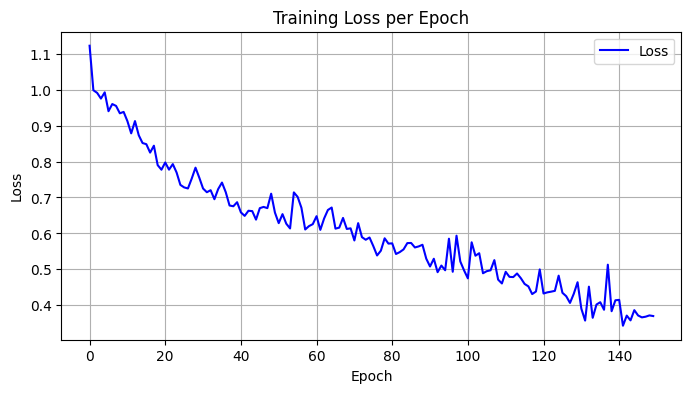

In [21]:
model = InformerClassifier(input_dim=1, d_model=64, n_heads=4, d_ff=128, n_layers=3, pred_len=30, n_classes=3)
accuracy, f1 = train_model(model, train_loader, num_epochs=150)

In [ ]:
torch.save(model.state_dict(), 'zika_model.pt')
print("Model saved to zika_model.pt")